In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
#scaler
from sklearn.preprocessing import StandardScaler
#model_selection
from sklearn.model_selection import cross_val_score
#PCA
from sklearn.decomposition import PCA

In [120]:
data = pd.read_csv('heart.csv')
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [121]:
#I calculate Z scores for RestingBP, Cholesterol, MaxHR columns.

data['RestingBP_zscore'] = (data.RestingBP-data.RestingBP.mean())/data.RestingBP.std()
data['Cholesterol_zscore'] = (data.Cholesterol-data.Cholesterol.mean())/data.Cholesterol.std()
data['MaxHR_zscore'] = (data.MaxHR-data.MaxHR.mean())/data.MaxHR.std()
data['Oldpeak_zscore'] = (data.Oldpeak-data.Oldpeak.mean())/data.Oldpeak.std()

filtered_data = data[(3>data.RestingBP_zscore) & (-3<data.RestingBP_zscore) & (3>data['Cholesterol_zscore'])& (data['Cholesterol_zscore']>-3) & (data['MaxHR_zscore']<3) & (data['MaxHR_zscore']>-3) & (data['Oldpeak_zscore']<3) & (data['Oldpeak_zscore']>-3)]
filtred_data = filtered_data[(filtered_data.RestingBP == 0) & (filtered_data.Cholesterol == 0) & (filtered_data.MaxHR == 0)]
# with this filter I removed about 20 outliers

In [122]:
filtered_data['RestingBP'].count()

899

In [123]:
final_data = filtered_data.drop(columns=['RestingBP_zscore', 'Cholesterol_zscore', 'MaxHR_zscore', 'Oldpeak_zscore'])

In [124]:
# now i want to convert columns with one hot encoding

data_with_dummies = pd.get_dummies(final_data, drop_first=True, dtype = int)
data_with_dummies
y = data_with_dummies.HeartDisease
X = data_with_dummies.drop(columns = ['HeartDisease'])
X.shape

(899, 15)

<Axes: >

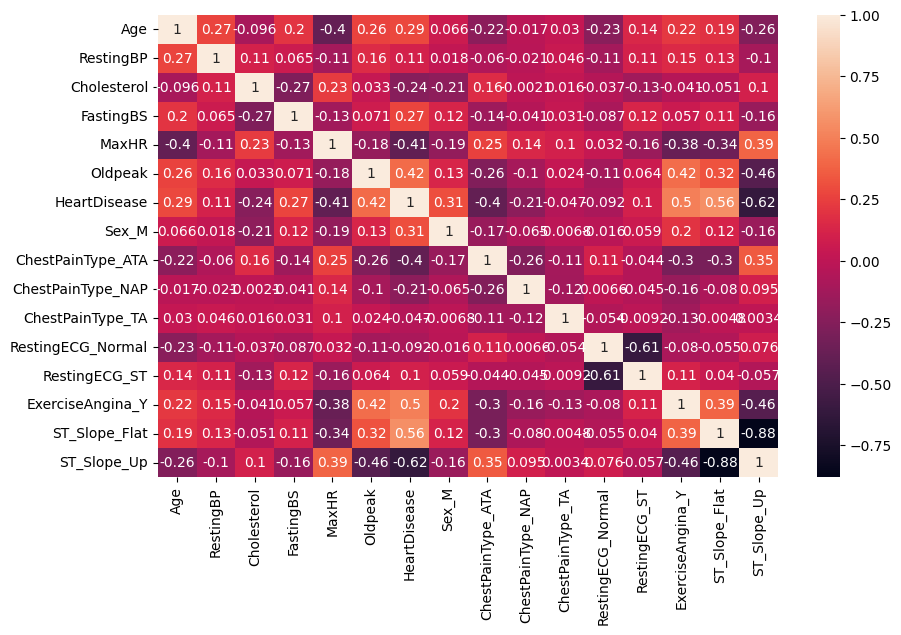

In [125]:
corr = data_with_dummies.corr()
plt.figure(figsize = (10,6))
sns.heatmap(corr , annot = True)

# None of the variables present a significative non-correlation with our target variable to be removed

In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [127]:
model_SVC = SVC(C = 10, kernel = 'linear')
model_SVC.fit(X_train, y_train)
score = model_SVC.score(X_test, y_test)
scores = cross_val_score(model_SVC, X_test, y_test, cv = 5)
print(f'SVC\'s accuracy was = {round(np.mean(scores),2)}')

SVC's accuracy was = 0.85


In [128]:
decision_tree = DecisionTreeClassifier(criterion='log_loss', max_depth=5, splitter='random')
decision_tree.fit(X_train,y_train)
dt_score = decision_tree.score(X_test,y_test)
dt_scores = cross_val_score(decision_tree, X_test, y_test, cv = 5)
print(f'Decision tree\'s accuracy was = {round(np.mean(dt_scores),2)}')

Decision tree's accuracy was = 0.82


In [129]:
# Now I am going to use bagging for both of the models and see if I get a better accuracy.

bagging_SVM = BaggingClassifier(
    estimator=SVC(C = 10, kernel = 'linear'),
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
)
SVM_scores = cross_val_score(bagging_SVM, X_scaled, y, cv=5)
SVM_scores.mean()
# For SVM we get a loss in accuracy when using baggin technique


0.8263873370577282

In [130]:
bagging_DT = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=5, splitter='random'),
    n_estimators=100,
    max_samples=0.8,
    oob_score=True,
)
DT_scores = cross_val_score(bagging_DT, X_scaled, y, cv=5)
DT_scores.mean()

# I don't see significant improvement from base models. Both of them got worse scores than before.

0.8308131595282433